# OBJECTIVE

## Using different neural network topologies, predict oil production in the province of Neuquen, Argentina within the next few years alongside crude oil prices, obtaining an estimation of the corresponding economic dividends.

In [27]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import tensorflow as tf
from fredapi import Fred

# Define some colors for later on
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# FRED API

The proper functioning of this notebook requires use of the freely-available FRED API. The user must supply their own API key. The user may supply their own key via an *API_key.txt* file in the same working directory of this notebook, or supply it after running the following code block.

## FRED API keys freely available at https://fred.stlouisfed.org/docs/api/api_key.html

In [28]:
# Try reading FRED API key file

keyfile = False
try:
    with open('FRED_API_KEY', 'r') as file:
        fred_key = file.read().strip()
    print(color.GREEN + color.BOLD + '\n===== FRED API KEY FOUND! =====' + color.END)
    keyfile = True
except:
    print(color.BOLD + color.RED + '===== FRED API KEY NOT FOUND! =====' + color.END)
    fred_key = input('Please supply user FRED API key:')

# Test FRED API key
print('\nTesting FRED API key...')
fred = Fred(api_key=fred_key)
print('Grabbing US GDP data...\n')
try:
    test_data = fred.get_series_first_release('GDP')
    print(test_data)
    print(color.GREEN + color.BOLD + '\n===== API key good, FRED server reachable! =====' + color.END)
except:
    print(color.RED + color.BOLD + '====== TEST FAILED! FRED API key invalid and/or FRED server unreachable (check internet connection). =====' + color.END)
    raise Exception()
    
# Offer to save FRED API in key 
while(not keyfile):
    save_prompt = input('\nSave FRED API key to current working directory for future use? y/[n]').lower()
    if (save_prompt == 'y'):
        try:
            print(fred_key,  file=open('FRED_API_KEY', 'w'))
            print(color.GREEN + 'API key saved to file FRED_API_KEY in current directory!' + color.END)
            break
        except:
            print(color.RED + color.BOLD + '====== COULD NOT WRITE API KEY TO FILE! Check current directory and/or file permissions. =====' + color.END)
    elif (save_prompt == 'n' or save_prompt == ''):
        break
    else:
        print(color.RED + 'Invalid character input. Try again.' + color.END)


===== FRED API KEY FOUND! =====

Testing FRED API key...
Grabbing US GDP data...

date
1946-01-01        199.7
1946-04-01        207.7
1946-07-01        217.9
1946-10-01        222.2
1947-01-01        226.7
                ...    
2022-10-01    26132.458
2023-01-01    26465.865
2023-04-01    26834.953
2023-07-01    27623.543
2023-10-01    27938.831
Name: value, Length: 312, dtype: object

===== API key good, FRED server reachable! =====


In [38]:
# Load CSV data 
nqn_pet = pd.read_csv('C:/Users/Felipe/Desktop/Data_Science_Road_2024/EDA/serie_tiempo_neuquen.csv')

nqn_pet['Produccion_Total_Petroleo']=nqn_pet['Produccion_Total_Petroleo']*(6.28981/1e6) #barriles de petroleo



len(nqn_pet)

nqn_pet=nqn_pet[['fecha','Produccion_Total_Petroleo']].copy()

# Convertir la columna 'fecha' a tipo datetime si aún no lo está
nqn_pet['fecha'] = pd.to_datetime(nqn_pet['fecha'])

# Establecer la columna 'fecha' como el índice
nqn_pet.set_index('fecha', inplace=True)

print(nqn_pet)


            Produccion_Total_Petroleo
fecha                                
2010-01-01                   0.002731
2010-02-01                   0.002742
2010-03-01                   0.003280
2010-04-01                   0.002754
2010-05-01                   0.002878
...                               ...
2023-07-01                   0.948677
2023-08-01                   0.906767
2023-09-01                   0.910139
2023-10-01                   0.984539
2023-11-01                   1.004743

[167 rows x 1 columns]


In [30]:
#SEARCH FOR CRUDE OIL PRICE

In [31]:
fred = Fred(api_key=fred_key)

In [32]:
Crude_oil=fred.search("crude oil prices", order_by="popularity")

In [33]:
Crude_oil.head(10)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
DCOILWTICO,DCOILWTICO,2024-02-06,2024-02-06,Crude Oil Prices: West Texas Intermediate (WTI...,1986-01-02,2024-01-29,Daily,D,Dollars per Barrel,$ per Barrel,Not Seasonally Adjusted,NSA,2024-01-31 12:12:01-06:00,77,"Definitions, Sources and Explanatory Notes (ht..."
DCOILBRENTEU,DCOILBRENTEU,2024-02-06,2024-02-06,Crude Oil Prices: Brent - Europe,1987-05-20,2024-01-29,Daily,D,Dollars per Barrel,$ per Barrel,Not Seasonally Adjusted,NSA,2024-01-31 12:11:02-06:00,70,"Definitions, Sources and Explanatory Notes (ht..."
WTISPLC,WTISPLC,2024-02-06,2024-02-06,Spot Crude Oil Price: West Texas Intermediate ...,1946-01-01,2023-12-01,Monthly,M,Dollars per Barrel,$ per Barrel,Not Seasonally Adjusted,NSA,2024-01-04 12:38:02-06:00,66,This series was created by the Federal Reserve...
POILBREUSDM,POILBREUSDM,2024-02-06,2024-02-06,Global price of Brent Crude,1990-01-01,2023-12-01,Monthly,M,U.S. Dollars per Barrel,U.S. $ per Barrel,Not Seasonally Adjusted,NSA,2024-01-24 13:36:04-06:00,59,Value represents the benchmark prices which ar...
MCOILWTICO,MCOILWTICO,2024-02-06,2024-02-06,Crude Oil Prices: West Texas Intermediate (WTI...,1986-01-01,2023-12-01,Monthly,M,Dollars per Barrel,$ per Barrel,Not Seasonally Adjusted,NSA,2024-01-04 12:21:02-06:00,56,"Definitions, Sources and Explanatory Notes: ht..."
MCOILBRENTEU,MCOILBRENTEU,2024-02-06,2024-02-06,Crude Oil Prices: Brent - Europe,1987-05-01,2023-12-01,Monthly,M,Dollars per Barrel,$ per Barrel,Not Seasonally Adjusted,NSA,2024-01-04 12:21:03-06:00,55,"Definitions, Sources and Explanatory Notes: ht..."
OVXCLS,OVXCLS,2024-02-06,2024-02-06,CBOE Crude Oil ETF Volatility Index,2007-05-10,2024-02-02,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-02-05 08:36:04-06:00,52,Exchange Traded Funds (ETFs) are shares of tru...
POILWTIUSDM,POILWTIUSDM,2024-02-06,2024-02-06,Global price of WTI Crude,1990-01-01,2023-12-01,Monthly,M,U.S. Dollars per Barrel,U.S. $ per Barrel,Not Seasonally Adjusted,NSA,2024-01-24 13:36:06-06:00,51,Value represents the benchmark prices which ar...
POILDUBUSDM,POILDUBUSDM,2024-02-06,2024-02-06,Global price of Dubai Crude,1990-01-01,2023-12-01,Monthly,M,U.S. Dollars per Barrel,U.S. $ per Barrel,Not Seasonally Adjusted,NSA,2024-01-24 13:36:10-06:00,41,Value represents the benchmark prices which ar...


In [37]:
CRUDE=fred.get_series(series_id="WTISPLC")

#CRUDE=CRUDE[['TIME', 'VALUE']]
#CRUDE.columns= ['TIME', 'VALUE'].copy()

#CRUDE = pd.to_datetime(CRUDE)

CRUDE_2010 = CRUDE[CRUDE.index.year >= 2010]

CRUDE_2010=CRUDE_2010.iloc[:-1]
print(CRUDE_2010)
print(nqn_pet)

2010-01-01    78.22
2010-02-01    76.42
2010-03-01    81.24
2010-04-01    84.48
2010-05-01    73.84
              ...  
2023-07-01    76.07
2023-08-01    81.39
2023-09-01    89.43
2023-10-01    85.64
2023-11-01    77.69
Length: 167, dtype: float64
            Produccion_Total_Petroleo
fecha                                
2010-01-01                   0.000249
2010-02-01                   0.000256
2010-03-01                   0.000655
2010-04-01                   0.000265
2010-05-01                   0.000357
...                               ...
2023-07-01                   0.700398
2023-08-01                   0.669378
2023-09-01                   0.671874
2023-10-01                   0.726942
2023-11-01                   0.741896

[167 rows x 1 columns]


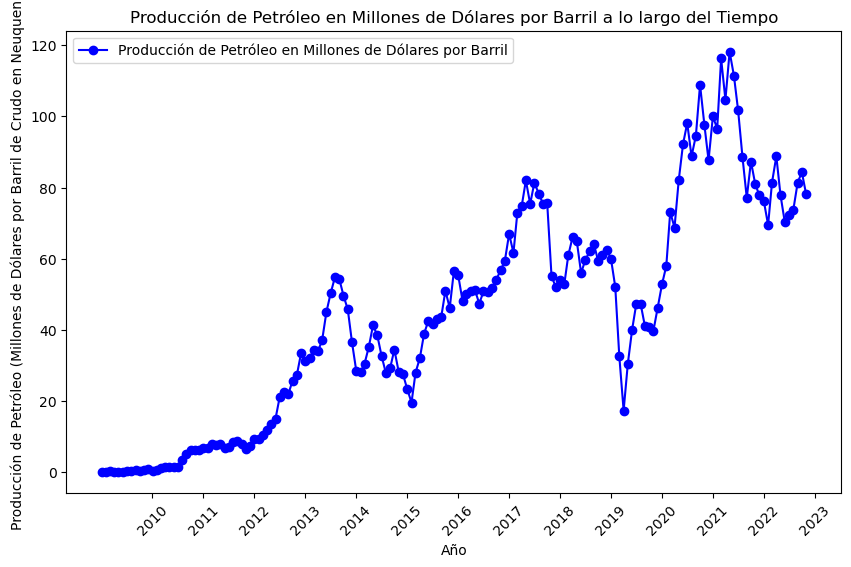

In [35]:
SMD=CRUDE_2010*nqn_pet["Produccion_Total_Petroleo"]

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar la serie de tiempo
ax.plot(SMD.index, SMD.values, marker='o', linestyle='-', color='b', label='Producción de Petróleo en Millones de Dólares por Barril')

# Configurar el eje x para mostrar solo años
ax.set_xticks(SMD.resample('Y').mean().index)
ax.set_xticklabels([str(year.year) for year in SMD.resample('Y').mean().index], rotation=45)

# Etiquetas y título
ax.set_xlabel('Año')
ax.set_ylabel('Producción de Petróleo (Millones de Dólares por Barril de Crudo en Neuquen)')
ax.set_title('Producción de Petróleo en Millones de Dólares por Barril a lo largo del Tiempo')

# Leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

# Predicciones

In [36]:
#vamos a normalizar las dos series de tiempo y luego dividir en dos set de datos 70% para entrenamiento y 30% para testeo
from sklearn.preprocessing import MinMaxScaler


nqn= nqn_pet["Produccion_Total_Petroleo"].values.reshape(-1, 1)  # Reshape to a 2D array for MinMaxScaler



# Creamos el objeto MinMaxScaler
scaler_min_max_scaler = MinMaxScaler()

# Normalizamos los datos y se agrega como nueva columna

nqn=scaler_min_max_scaler.fit_transform(nqn)



nqn_pet["Produccion_Total_Petroleo"] = nqn.flatten()


nqn_pet.head()

,Produccion_Total_Petroleo
fecha,
2010-01-01,0.000249
2010-02-01,0.000256
2010-03-01,0.000655
2010-04-01,0.000265
2010-05-01,0.000357


In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


seq_length=12 #anual
# Construir el modelo de red neuronal
#model = tf.keras.Sequential([
 #   tf.keras.layers.LSTM(32,activation="relu", input_shape=(seq_length, 1)),
  #  tf.keras.layers.LSTM(64, activation="relu"),
   # tf.keras.layers.Dense(1, activation="softmax")
#])


#model = Sequential()
#model.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.5,
                #     return_sequences=True, input_shape=(seq_length, 1)))

#model.add(layers.LSTM(64, activation='relu',
                 #    dropout=0.1, recurrent_dropout=0.5))

#model.add(layers.Dense(1))




model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5,
                     return_sequences=True, input_shape=(seq_length, 1)))

model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, recurrent_dropout=0.5, return_sequences=True))

model.add(layers.GRU(128, activation='relu',
                     dropout=0.1, recurrent_dropout=0.5))


model.add(layers.Dense(1))








# Compilar el modelo'
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse','acc' ])

# Resumen del modelo
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 12, 64)            18816     
                                                                 
 gru_2 (GRU)                 (None, 128)               74496     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 96,801
Trainable params: 96,801
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Definimos el tamaño del conjunto de entrenamiento (por ejemplo, el 70% de los datos)
train_size = int(len(nqn) * 0.6)

# Dividimos los datos en conjuntos de entrenamiento y prueba de manera secuencial
train_data, test_data = nqn[:train_size], nqn[train_size:]


seq_length= 12  # ajusta este valor según tus necesidades

# Crear las secuencias de entrada y salida para entrenamiento
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


# Convierte a arrays numpy
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [13]:
X_train.shape


(88, 12, 1)

In [14]:
X = np.array(X_train).reshape(-1, seq_length, 1)
y = np.array(y_train)

# Imprimir la forma de los datos de entrada
print("Forma de X:", X.shape)  # Salida esperada: (número de secuencias, longitud de secuencia, número de características)
print("Forma de y:", y.shape)  # Salida esperada: (número de sec



#Go_train


model.fit(X_train, y_train, epochs=15)






Forma de X: (88, 12, 1)
Forma de y: (88, 1)
Epoch 1/15
3/3 [==============================] - 9s 56ms/step - loss: 0.1903 - mse: 0.1903 - acc: 0.0000e+00
Epoch 2/15
3/3 [==============================] - 0s 55ms/step - loss: 0.1129 - mse: 0.1129 - acc: 0.0000e+00
Epoch 3/15
3/3 [==============================] - 0s 55ms/step - loss: 0.0520 - mse: 0.0520 - acc: 0.0000e+00
Epoch 4/15
3/3 [==============================] - 0s 53ms/step - loss: 0.0268 - mse: 0.0268 - acc: 0.0000e+00
Epoch 5/15
3/3 [==============================] - 0s 55ms/step - loss: 0.0329 - mse: 0.0329 - acc: 0.0000e+00
Epoch 6/15
3/3 [==============================] - 0s 57ms/step - loss: 0.0148 - mse: 0.0148 - acc: 0.0000e+00
Epoch 7/15
3/3 [==============================] - 0s 61ms/step - loss: 0.0119 - mse: 0.0119 - acc: 0.0000e+00
Epoch 8/15
3/3 [==============================] - 0s 58ms/step - loss: 0.0103 - mse: 0.0103 - acc: 0.0000e+00
Epoch 9/15
3/3 [==============================] - 0s 56ms/step - loss: 0.009

3/3 [==============================] - 1s 12ms/step


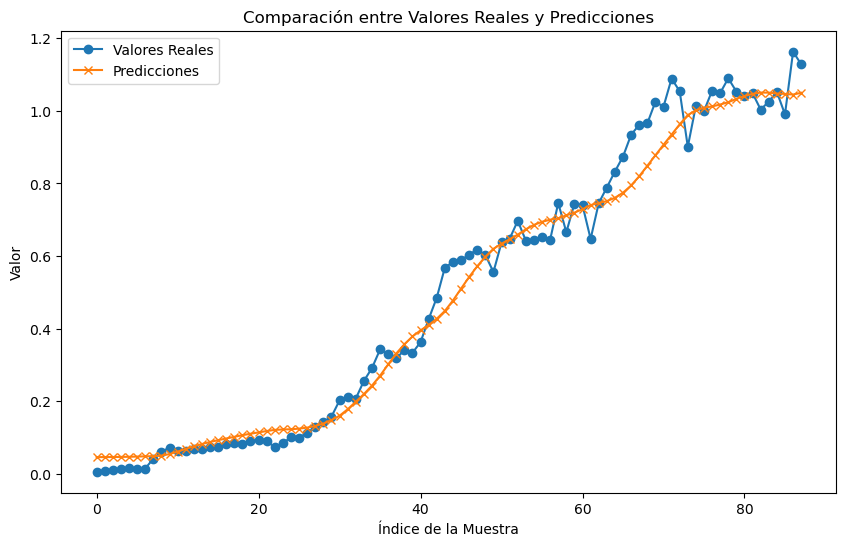

In [15]:


predictions_t=model.predict(X_train)
predictions_t=scaler_min_max_scaler.inverse_transform(predictions_t)
y_train = scaler_min_max_scaler.inverse_transform(y_train)


# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar los valores reales
plt.plot(y_train, label='Valores Reales', marker='o')

# Graficar las predicciones
plt.plot(predictions_t, label='Predicciones', marker='x')

plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Valor')
plt.legend()
plt.show()




2/2 [==============================] - 0s 15ms/step


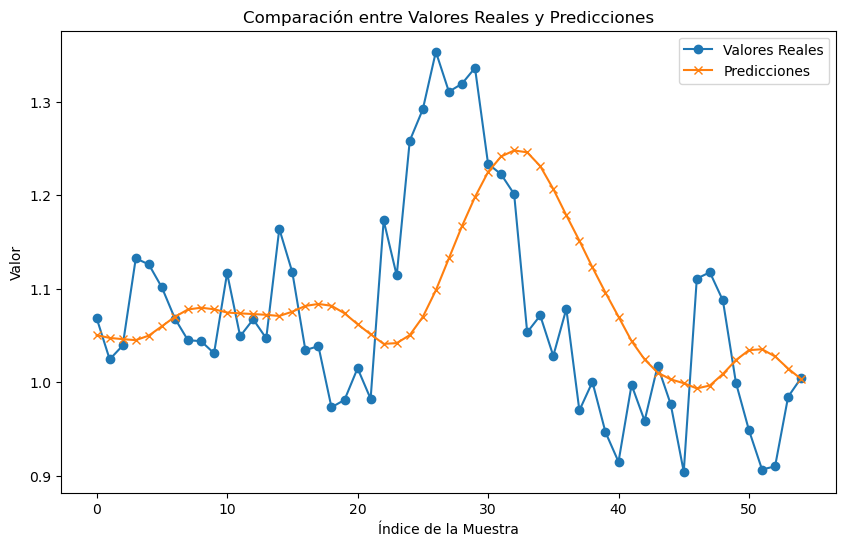

In [16]:
# Realizar predicciones con el modelo entrenado
predictions = model.predict(X_test)

predictions = scaler_min_max_scaler.inverse_transform(predictions)
y_test = scaler_min_max_scaler .inverse_transform(y_test)



# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar los valores reales
plt.plot(y_test, label='Valores Reales', marker='o')

# Graficar las predicciones
plt.plot(predictions, label='Predicciones', marker='x')

plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Valor')
plt.legend()
plt.show()



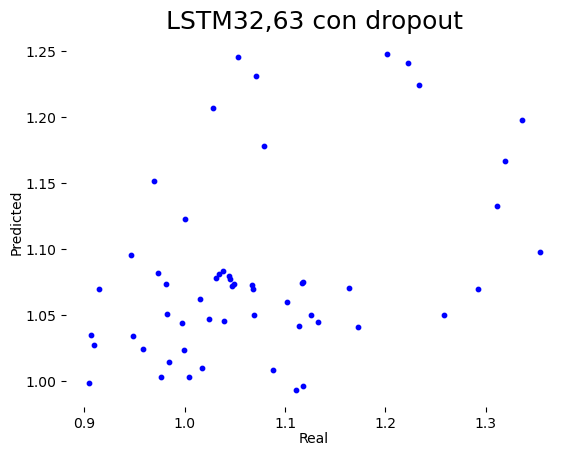

In [17]:

def graph_real_pred(y_test, y_pred_train, color, title, ax=None):
    """
    Funcion que grafica los valores reales vs. predichos
    :param y_test: valores reales
    :param y_pred_train: valores predichos
    :param color: color para el plot.
    :param title: título del gráfico
    :param ax: objeto de ejes de Matplotlib para dibujar el gráfico (opcional)
    :return: Scatterplot mostrando la relación entre el valor real y el predicho
    """
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(y_test, y_pred_train, c=color, s=10)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Real', size=10, labelpad=1)
    ax.set_ylabel('Predicted', size=10, labelpad=1)
    ax.set_title(title, size=18)  # Agregamos título al gráfico




graph_real_pred(y_test, predictions,"blue","LSTM32,63 con dropout" )

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 0.01111292295803806
R^2 Score: 0.11881926451705205


Un r2 negativo significa que el modelo es realmente inapropiado para los datos y que las predicciones son peores que simplemente usar la media de los valores observados como predicción. Esto puede ocurrir cuando el modelo tiene un rendimiento muy deficiente y está realizando predicciones extremadamente alejadas de los valores reales.

En primer lugar probé con una LSTM con 32 unidades (Fig. 1).

En segundo lugar uni dos LSTM con 32 y 64 unidades respectivamente. El resultado mejoró notablemente, porque lo que se buscaba era que siguiera la tendencia alsista (Fig. 2).

Asi que aumenté la profundidad agregando otra capa de 128 unidades y estos fueron los resultados (Fig. 3).


Combine una Conv1D con Maxpooling y una GRU 32 unidades (Fig. 4).

Y por último agregue una capa más GRU 64 a ver si mejoraba el resultado (Fig 5).


In [19]:
# Define future dates for the next 3 years
future_dates = pd.date_range(start=nqn_pet.index[-1] + pd.Timedelta(days=30),  periods=3*12, freq='M')

# Prepare the last sequence of scaled closing prices as input for prediction
future_seq = nqn[-seq_length:].reshape(1, seq_length, 1)

future_seq

# Make predictions for the next 5 years
future_pred = []

for _ in range(3*12):
    # Predict the next value using the GRU model
    next_pred = model.predict(future_seq)[0][0]
    
    # Append the predicted value to the list of future predictions
    future_pred.append(next_pred)
    
    # Update the input sequence for the next prediction
    future_seq = np.append(future_seq[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse transform the predicted values back to the original scale
future_pred = scaler_min_max_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))


1/1 [==============================] - 0s 43ms/step


In [21]:
# Define future dates for the next 5 years
future_dates = pd.date_range(start=nqn_pet.index[-1] + pd.Timedelta(days=30),  periods=3*12, freq='M')

# Prepare the last sequence of scaled closing prices as input for prediction
future_seq = nqn[-seq_length:].reshape(1, seq_length, 1)

# Make predictions for the next 5 years
future_pred = []

for _ in range(3*12):
    # Predict the next value using the LSTM model
    next_pred = model.predict(future_seq)[0][0]
    
    # Append the predicted value to the list of future predictions
    future_pred.append(next_pred)
    
    # Update the input sequence for the next prediction
    future_seq = np.append(future_seq[:, 1:, :], [[[next_pred]]], axis=1)

# Inverse transform the predicted values back to the original scale
future_pred = scaler_min_max_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))




1/1 [==============================] - 0s 44ms/step


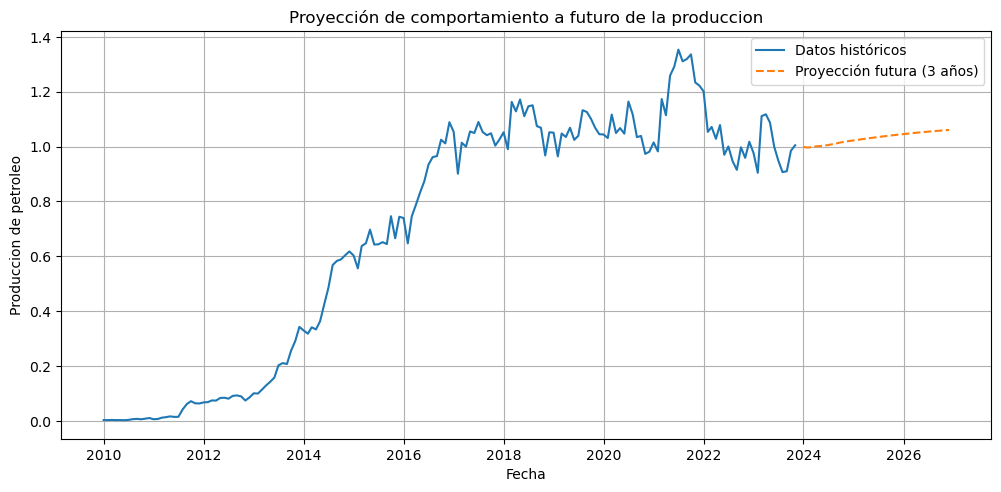

In [39]:
# Gráfico para la proyección futura

nqn_pet1 = pd.read_csv('C:/Users/Felipe/Desktop/Data_Science_Road_2024/EDA/serie_tiempo_neuquen.csv')

nqn_pet1['Produccion_Total_Petroleo']=nqn_pet1['Produccion_Total_Petroleo']*(6.28981/1e6) #barriles de petroleo






plt.figure(figsize=(12, 18))


plt.subplot(3, 1, 3)
plt.plot(nqn_pet, label='Datos históricos')
plt.plot(future_dates, future_pred, linestyle='--', label='Proyección futura (3 años)')
plt.title('Proyección de comportamiento a futuro de la produccion')
plt.xlabel('Fecha')
plt.ylabel('Produccion de petroleo')
plt.legend()
plt.grid(True)

